# **Data-set loading and pre-processing**

This script contains the code to download the dataset for 10 classes, shuffle the data and split it into training and testing. The script contains other methods (t-SNE plotting for instance).

In [2]:
!wget https://raw.githubusercontent.com/zaidalyafeai/QuickDraw10/master/quick_draw10.py

--2022-04-16 11:53:19--  https://raw.githubusercontent.com/zaidalyafeai/QuickDraw10/master/quick_draw10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2815 (2.7K) [text/plain]
Saving to: ‘quick_draw10.py’

quick_draw10.py     100%[===================>]   2.75K  --.-KB/s    in 0s      

2022-04-16 11:53:19 (51.0 MB/s) - ‘quick_draw10.py’ saved [2815/2815]



**Import libraries**

In [3]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from quick_draw10 import download_and_load, plot_tsne
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

**Load the data**

In [4]:
x_train, y_train, x_test, y_test, class_names = download_and_load()

downloading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cloud.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pants.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/umbrella.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/table.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/scissors.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cup.npy
loading ...
Training Data :  80000
Testing  Data :  20000


In [5]:
class_names

['cloud',
 'sun',
 'pants',
 'umbrella',
 'table',
 'ladder',
 'eyeglasses',
 'clock',
 'scissors',
 'cup']

**Data Visualization**

In [6]:
def visualize_classes():
  for i in range(0, 10):
    img_batch = x_train[y_train == i][0:10]
    img_batch = np.reshape(img_batch, (img_batch.shape[0]*img_batch.shape[1], img_batch.shape[2]))
    if i > 0:
      img = np.concatenate([img, img_batch], axis = 1)
    else:
      img = img_batch
  plt.figure(figsize=(10,20))
  plt.axis('off')
  plt.imshow(img)

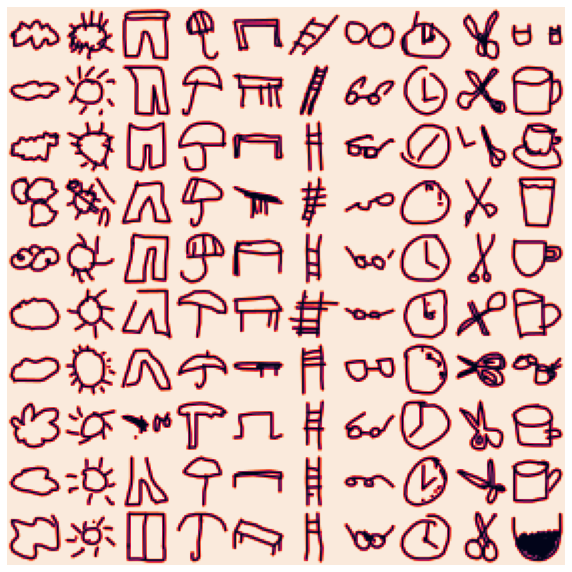

In [7]:
visualize_classes()

**Labels distirubtion**

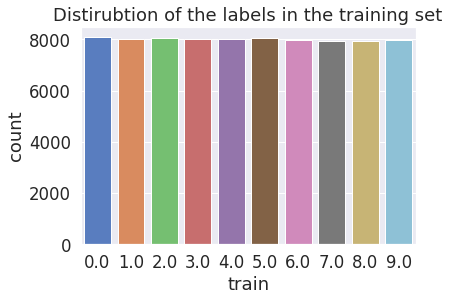

In [8]:
data = {}
data['train'] = y_train
df = pd.DataFrame.from_dict(data)
ax = sns.countplot(x = 'train', data=df).set_title("Distirubtion of the labels in the training set")

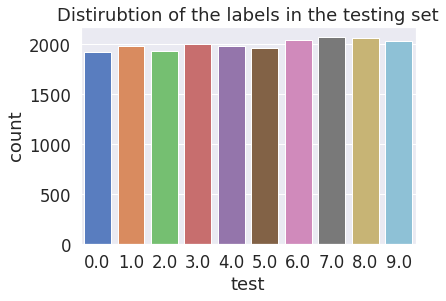

In [9]:
data = {}
data['test'] = y_test
df = pd.DataFrame.from_dict(data)
ax = sns.countplot(x = 'test', data=df).set_title("Distirubtion of the labels in the testing set")

**T-SNE**

calculating tsne ...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


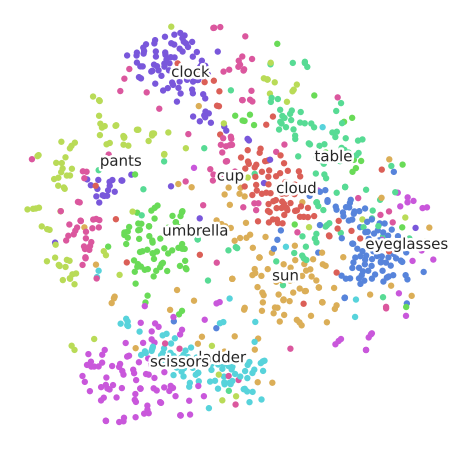

In [10]:
X = np.reshape(x_train, (x_train.shape[0], 28 * 28))[0:1000]
y = y_train[0:1000]
plot_tsne(X, y)

**Preprocess the Data**

In [11]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (80000, 28, 28, 1) 1.0
Testing (20000, 28, 28, 1) 1.0


In [12]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [8079, 8019, 8063, 7994, 8014, 8042, 7956, 7930, 7936, 7967]
test groups: [1921, 1981, 1937, 2006, 1986, 1958, 2044, 2070, 2064, 2033]


**Batch Generation**

In [13]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

**Validate Data**

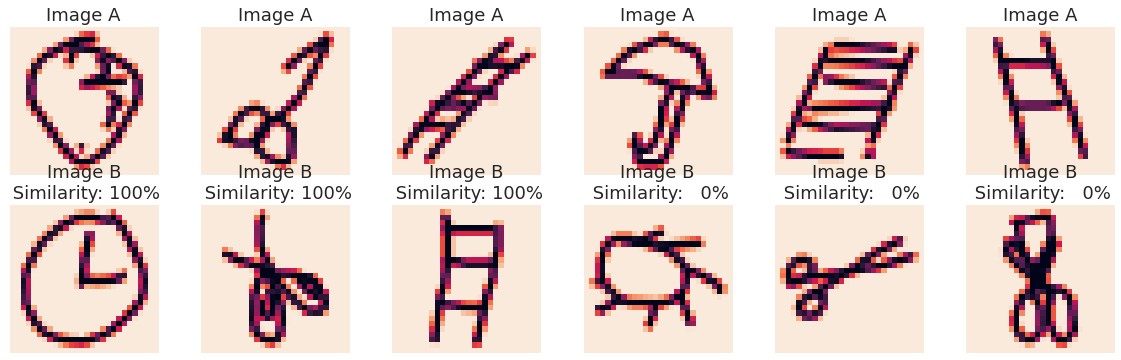

In [14]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (20, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [15]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24,

In [17]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 32)          25040       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 64)           0           ['FeatureGeneratio

In [18]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

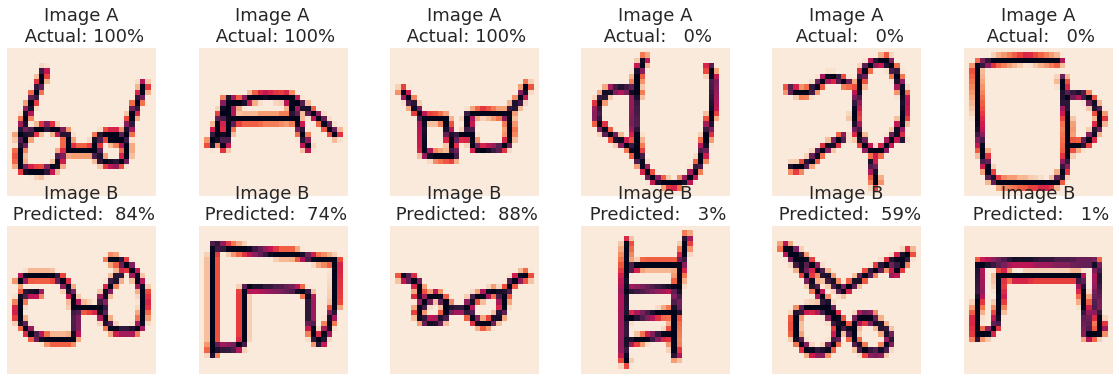

In [21]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (20, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [20]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10,
                                             verbose = True)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


500/500 [==============================] - 32s 55ms/step - loss: 0.6931 - mae: 0.4927 - val_loss: 0.6494 - val_mae: 0.4704
Epoch 2/10
500/500 [==============================] - 32s 65ms/step - loss: 0.6377 - mae: 0.4588 - val_loss: 0.5813 - val_mae: 0.4182
Epoch 3/10
500/500 [==============================] - 30s 59ms/step - loss: 0.5849 - mae: 0.4124 - val_loss: 0.5285 - val_mae: 0.3702
Epoch 4/10
500/500 [==============================] - 29s 57ms/step - loss: 0.5433 - mae: 0.3773 - val_loss: 0.4526 - val_mae: 0.3130
Epoch 5/10
500/500 [==============================] - 29s 57ms/step - loss: 0.4954 - mae: 0.3359 - val_loss: 0.4407 - val_mae: 0.2939
Epoch 6/10
500/500 [==============================] - 29s 57ms/step - loss: 0.4685 - mae: 0.3095 - val_loss: 0.3997 - val_mae: 0.2556
Epoch 7/10
500/500 [==============================] - 28s 57ms/step - loss: 0.4490 - mae: 0.2924 - val_loss: 0.4031 - val_mae: 0.2467
Epoch 8/10
500/500 [==============================] - 25s 50ms/step - los

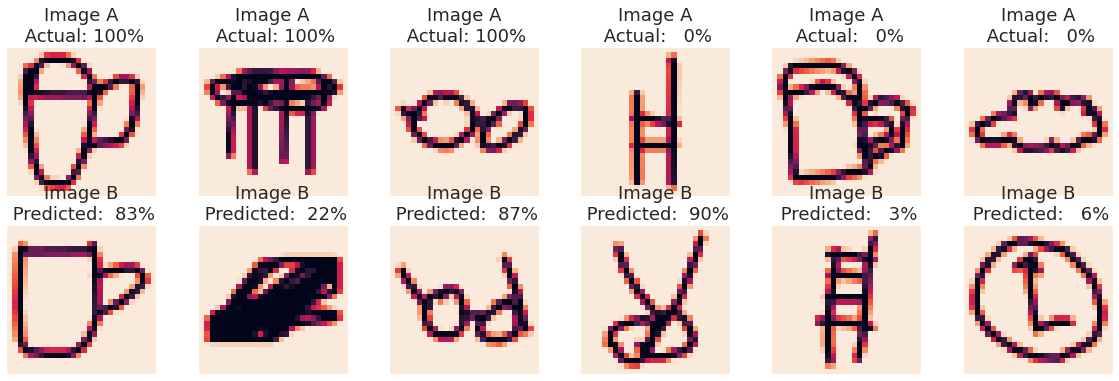

In [22]:
_ = show_model_output()